Problem description

Before the company can create new solar farms to maximize its profits, the question naturally arises:

Where should we place the new solar farms to maximize our profit and at the same time meet our increasing customer demand for electricity?
Scenario 1: New demand for electricity: 2 million kWh/a.
Scenario 2: New demand for electricity: 3 million kWh/a.

Limitations and Information

Unfortunately, Smart Energy LLC cannot provide unlimited financial resources, and there are restrictions on geographic location
and construction.
Management imposed limitations and information:
- We divide our country into 4 regions (North-West, North-East, South-West and South-East) for simplicity.
- In order that all people in our country have short distances in the power supply, at least 100m2 of solar farm must be built in each region.
- Unfortunately, the building space in the regions is limited so may be built in the regions max following area:
- North-West: 3,000m2
- North-East: 3,000m2
- South-West: 2,000 m2
- South-East: 2,000m2
- For one square meter of solar plant Smart Energy LLC has to pay 100€ for the material plus the cost of the land.
- Currently Smart Energy LLC can invest only 2 million €.
- In order to fulfill scenario 2, a budget of 3 million € can be invested.
- In order to perform the analysis, 2 data sets are available:
- Sunshine hours and land prices by geographic location.
- Database of already installed solar farms

In [62]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
df = pd.read_excel('Environment Solar Data.xlsx')
coords = df[["Latitude", "Longitude"]].values

In [63]:
df

,Date,Longitude,Latitude,Sunhine Hours,Avg. Wind Speed,Property prices
0,2018-01-01,0.220,0.270,45.36,2.560,304.0
1,2018-01-01,0.280,0.230,34.02,3.216,318.0
2,2018-01-01,0.280,0.270,45.36,3.144,102.0
3,2018-01-01,0.350,0.200,30.78,3.664,248.0
4,2018-01-01,0.180,0.300,33.21,2.632,326.0
...,...,...,...,...,...,...
3299,2022-08-01,0.873,0.379,170.40,4.410,115.0
3300,2022-08-01,0.856,0.100,160.00,3.852,112.0
3301,2022-08-01,0.233,0.623,122.40,3.015,73.0
3302,2022-08-01,0.567,0.727,181.60,3.870,149.0


In [64]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))


Number of clusters: 56


In [65]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)


In [66]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})


In [67]:
rs = rep_points.apply(lambda row: df[(df['Latitude']==row['Latitude']) & (df['Longitude']==row['Longitude'])].iloc[0], axis=1)


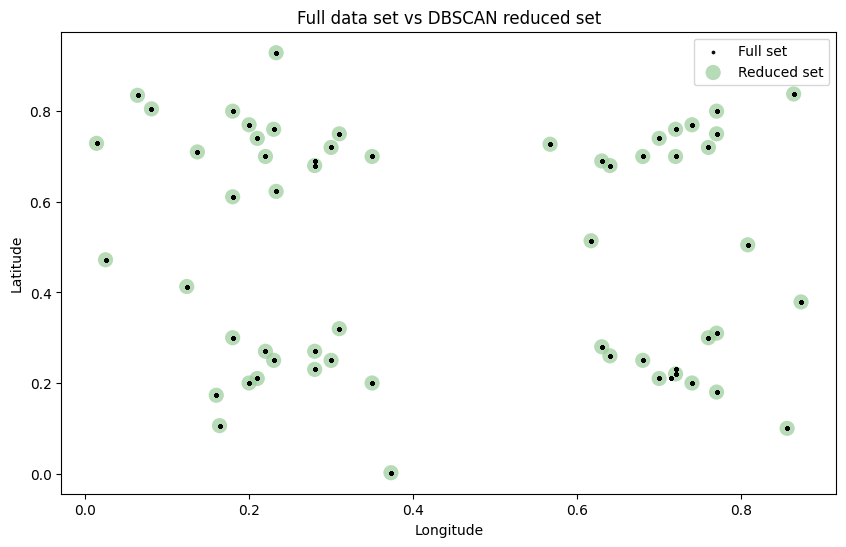

In [68]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

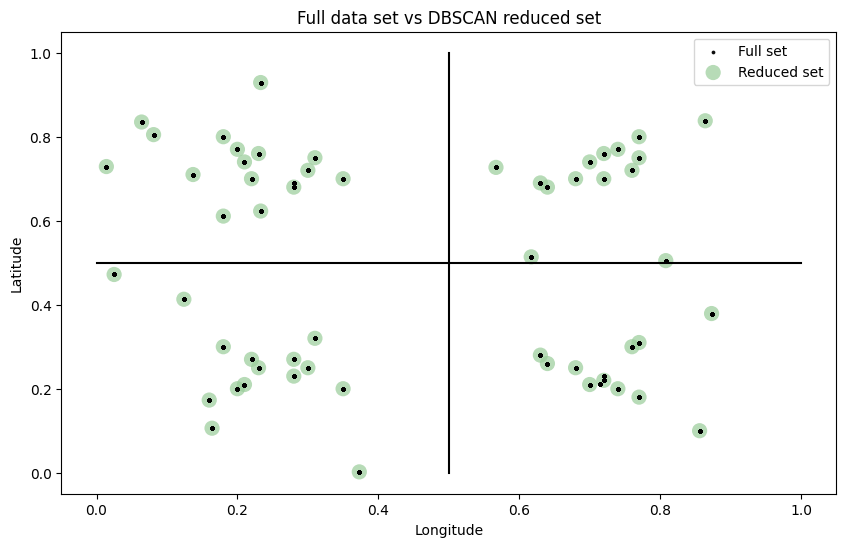

In [69]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.plot([0, 1.0], [0.5, 0.5], 'k-') # draw x-axis
plt.plot([0.5, 0.5], [0, 1.0], 'k-') # draw y-axis
plt.show()

# Another Solution

In [70]:
solar = pd.read_excel("Installed Solar Plants.xlsx")
solar.head()

,Model ID,Sunshine Hours per year,Size Solar Panel m2,Generated energy kWh/a
0,1,1418,794,233616
1,2,1474,1726,525410
2,3,1335,5776,1612292
3,4,1224,6494,1681651
4,5,1320,2085,576313


In [71]:
df.head()

,Date,Longitude,Latitude,Sunhine Hours,Avg. Wind Speed,Property prices
0,2018-01-01,0.22,0.27,45.36,2.560,304.0
1,2018-01-01,0.28,0.23,34.02,3.216,318.0
2,2018-01-01,0.28,0.27,45.36,3.144,102.0
3,2018-01-01,0.35,0.20,30.78,3.664,248.0
4,2018-01-01,0.18,0.30,33.21,2.632,326.0


In [72]:
df.isnull().sum()

,0
Date,0
Longitude,0
Latitude,0
Sunhine Hours,2
Avg. Wind Speed,1
Property prices,1


In [73]:
df=df.dropna().reset_index()
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df["week"] = df['Date'].dt.isocalendar().week
df.head()

,index,Date,Longitude,Latitude,Sunhine Hours,Avg. Wind Speed,Property prices,year,month,day,week
0,0,2018-01-01,0.22,0.27,45.36,2.560,304.0,2018,1,1,1
1,1,2018-01-01,0.28,0.23,34.02,3.216,318.0,2018,1,1,1
2,2,2018-01-01,0.28,0.27,45.36,3.144,102.0,2018,1,1,1
3,3,2018-01-01,0.35,0.20,30.78,3.664,248.0,2018,1,1,1
4,4,2018-01-01,0.18,0.30,33.21,2.632,326.0,2018,1,1,1


In [74]:
import datetime as dt

In [75]:
df.groupby("year")['Property prices'].agg({"sum","mean", "median"})

,mean,sum,median
year,,,
2018,146.618980,103513.0,126.0
2019,146.857143,103828.0,126.0
2020,146.779661,103920.0,126.0
2021,146.871287,103838.0,126.0
2022,146.779661,69280.0,126.0


<Axes: xlabel='year'>

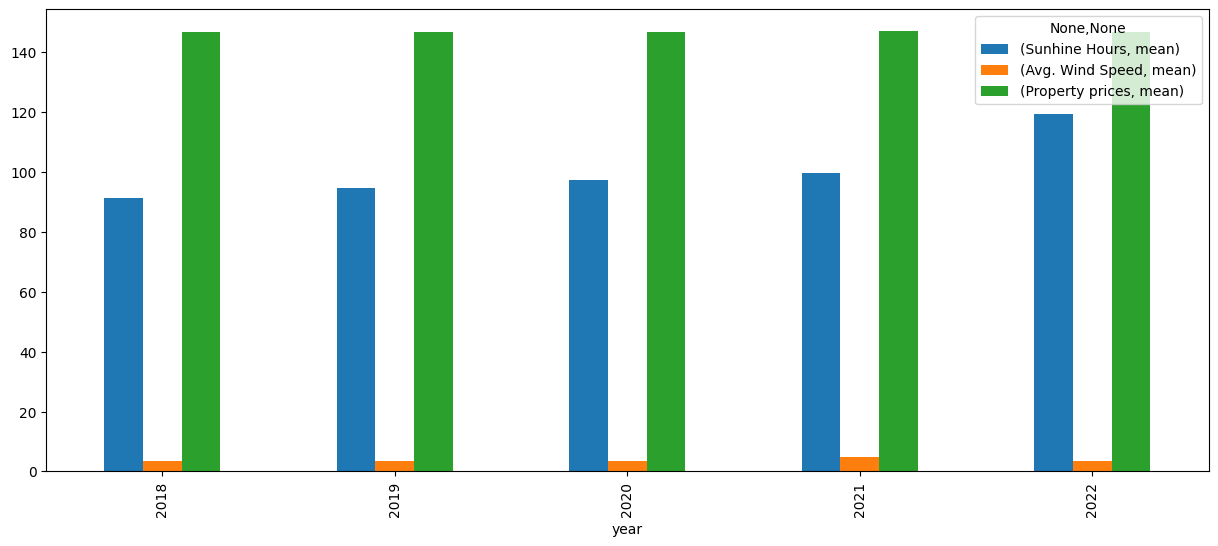

In [76]:
df.groupby("year")[["Sunhine Hours",
                   "Avg. Wind Speed",
                   "Property prices"]].agg({"mean"}).plot(kind = "bar", figsize = (15,6))

<Axes: xlabel='year'>

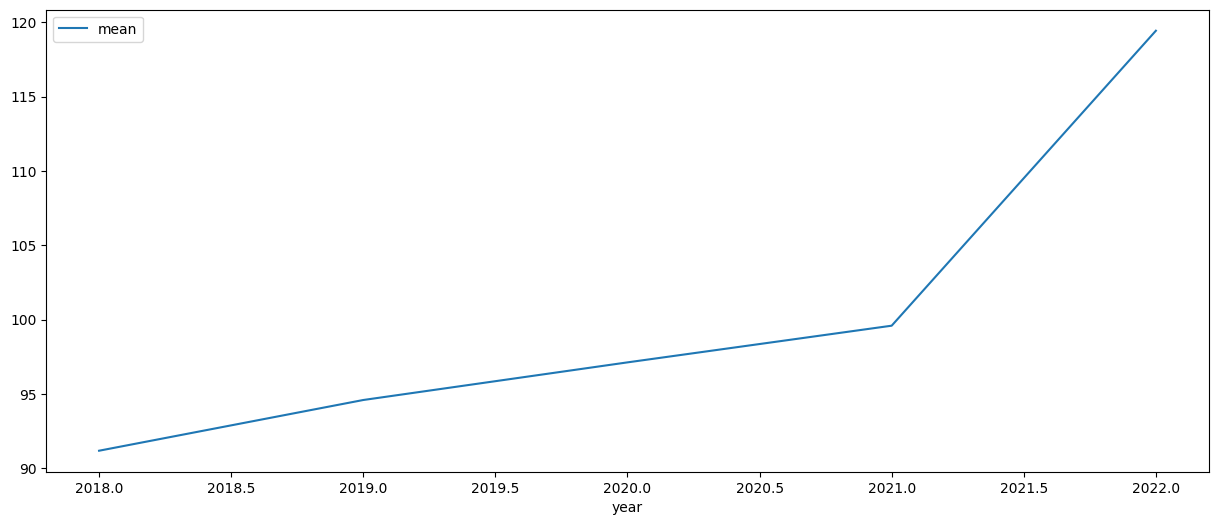

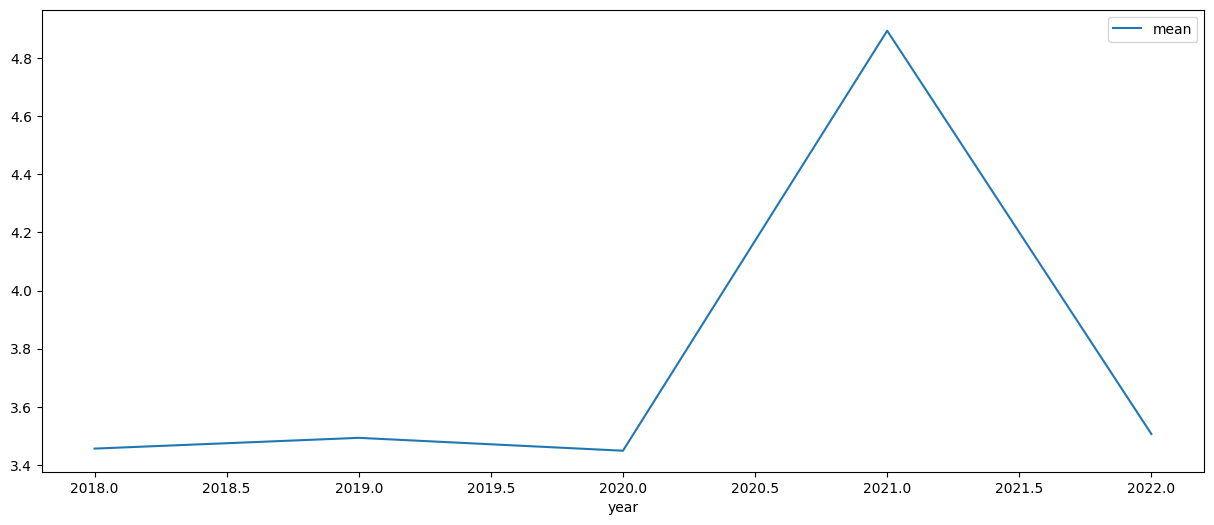

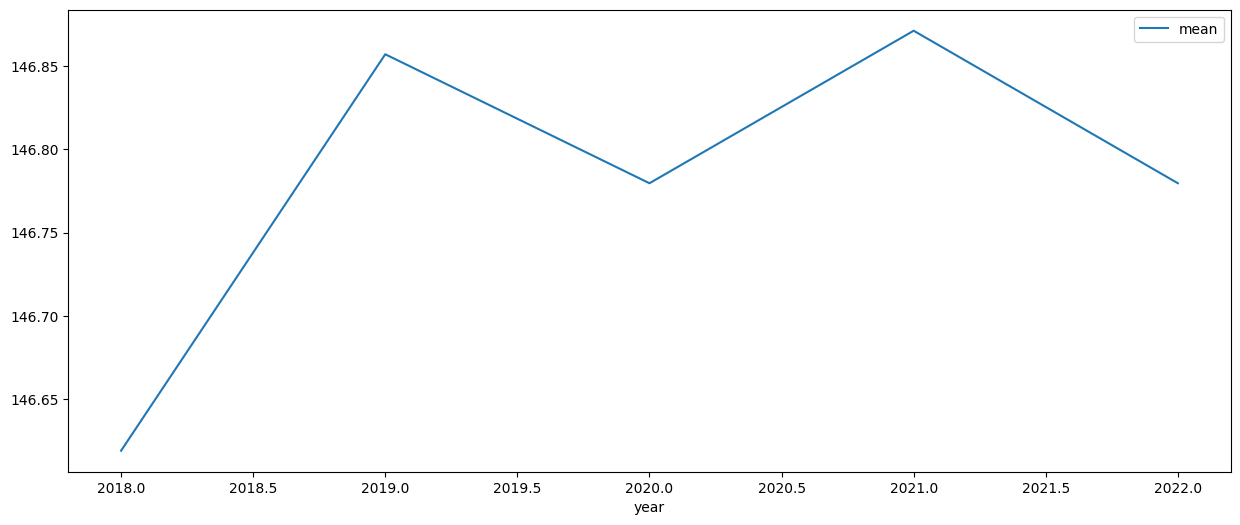

In [77]:
# Sunhine Hours
df.groupby("year")["Sunhine Hours"].agg({"mean"}).plot(figsize = (15,6))
df.groupby("year")["Avg. Wind Speed"].agg({"mean"}).plot(figsize = (15,6))
df.groupby("year")["Property prices"].agg({"mean"}).plot(figsize = (15,6))

In [78]:
df['point'] = df[['Longitude','Latitude']].values.tolist()

# seperate regions
sw = df[(df['Longitude'] < 0.5) & (df['Latitude'] < 0.5)]
nw = df[(df['Longitude'] < 0.5) & (df['Latitude'] > 0.5)]
ne = df[(df['Longitude'] > 0.5) & (df['Latitude'] > 0.5)]
se = df[(df['Longitude'] > 0.5) & (df['Latitude'] < 0.5)]

sw_center = get_centermost_point(sw['point'].tolist())
nw_center = get_centermost_point(nw['point'].tolist())
ne_center = get_centermost_point(ne['point'].tolist())
se_center = get_centermost_point(se['point'].tolist())

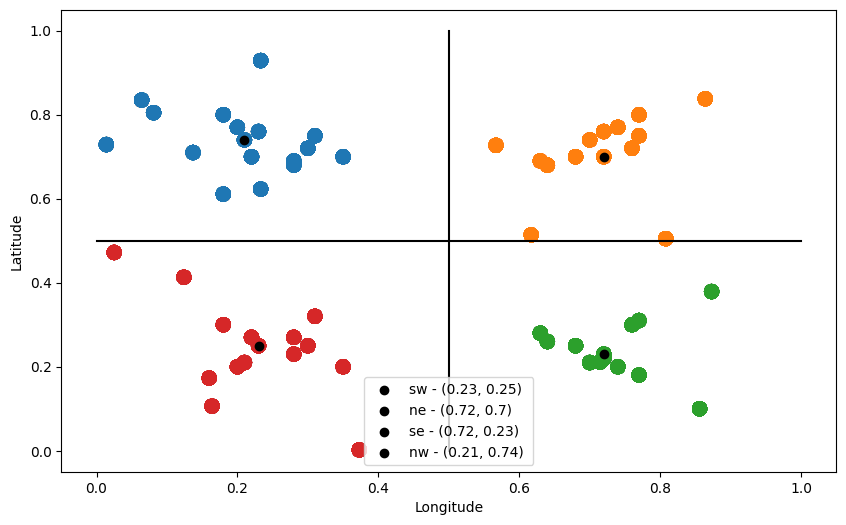

In [79]:
plt.figure(figsize=(10,6))
plt.scatter(nw['Longitude'], nw['Latitude'], edgecolor='None', alpha=0.7, s=120)
plt.scatter(ne['Longitude'], ne['Latitude'], edgecolor='None', alpha=0.7, s=120)
plt.scatter(se['Longitude'], se['Latitude'], edgecolor='None', alpha=0.7, s=120)
plt.scatter(sw['Longitude'], sw['Latitude'], edgecolor='None', alpha=0.7, s=120)
plt.scatter(sw_center[0], sw_center[1], label = f"sw - {sw_center} ", c='black')
plt.scatter(ne_center[0], ne_center[1], label = f"ne - {ne_center} ", c = 'black')
plt.scatter(se_center[0], se_center[1], label = f"se - {se_center} ", c = 'black')
plt.scatter(nw_center[0], nw_center[1], label = f"nw - {nw_center} ", c = 'black')
plt.plot([0, 1.0], [0.5, 0.5], 'k-') # draw x-axis
plt.plot([0.5, 0.5], [0, 1.0], 'k-') # draw y-axis
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [80]:
df.groupby(["Longitude", "Latitude"])['Property prices'].agg(['sum', 'count'])


,,sum,count
Longitude,Latitude,,
0.014,0.729,3752.0,56
0.025,0.472,6496.0,56
0.064,0.835,5096.0,56
0.081,0.805,3640.0,56
0.124,0.413,7056.0,56
0.137,0.710,4816.0,56
0.160,0.173,7150.0,55
0.164,0.106,5320.0,56
0.180,0.300,18256.0,56


In [81]:
df.groupby(["Longitude", "Latitude"])['Sunhine Hours'].agg(['sum', 'count'])

,,sum,count
Longitude,Latitude,,
0.014,0.729,5399.0000,56
0.025,0.472,5280.9600,56
0.064,0.835,5317.9800,56
0.081,0.805,5277.9000,56
0.124,0.413,5415.9200,56
0.137,0.710,5510.5000,56
0.160,0.173,5333.7600,55
0.164,0.106,5232.6800,56
0.180,0.300,6025.7025,56


In [27]:
nw

,level_0,index,Date,Longitude,Latitude,Sunhine Hours,Avg. Wind Speed,Property prices,year,month,day,week,point
10,10,10,2018-01-01,0.220,0.700,34.83,2.504,174.0,2018,1,1,1,"[0.22, 0.7]"
11,11,11,2018-01-01,0.280,0.680,38.88,3.176,131.0,2018,1,1,1,"[0.28, 0.68]"
12,12,12,2018-01-01,0.280,0.690,39.69,3.792,330.0,2018,1,1,1,"[0.28, 0.69]"
13,13,13,2018-01-01,0.350,0.700,32.40,2.760,277.0,2018,1,1,1,"[0.35, 0.7]"
14,14,14,2018-01-01,0.180,0.800,32.40,2.784,276.0,2018,1,1,1,"[0.18, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3288,3288,3292,2022-08-01,0.137,0.710,180.80,3.150,86.0,2022,8,1,31,"[0.137, 0.71]"
3289,3289,3293,2022-08-01,0.064,0.835,127.20,2.826,91.0,2022,8,1,31,"[0.064, 0.835]"
3291,3291,3295,2022-08-01,0.014,0.729,176.00,3.033,67.0,2022,8,1,31,"[0.014, 0.729]"
3297,3297,3301,2022-08-01,0.233,0.623,122.40,3.015,73.0,2022,8,1,31,"[0.233, 0.623]"


In [82]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.optimize import minimize
from shapely.geometry import Point

def create_model(data, long_bound, lat_bound, long_init, lat_init):
  X = data.loc[:, ["Longitude", "Latitude", "Sunhine Hours", "Avg. Wind Speed"]]
  y = data.loc[:, "Property prices"]

  rf = RandomForestRegressor()

  random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 30, 50, 70, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [25, 50, 100, 200, 400, 800, 1000]
  }

  model = RandomizedSearchCV(estimator = rf,
                            param_distributions = random_grid,
                            n_iter = 50, cv = 3,
                            verbose= 1,
                            n_jobs= 2,
                            random_state=42).fit(X,y)


  # Use optimization to find the optimal price
  def profit_function(params):
    longitude, latitude, sunshine_hours, avg_wind_speed = params
    location = Point(longitude, latitude)
    price = model.predict([[location.x, location.y, sunshine_hours, avg_wind_speed]])[0]
    return -price

  bounds = [long_bound,
            lat_bound,
            (data["Sunhine Hours"].min(), data["Sunhine Hours"].max()),
            (data["Avg. Wind Speed"].min(), data["Avg. Wind Speed"].max())]

  # Set initial guess
  x0 = [long_init, lat_init, data["Sunhine Hours"].mean() , data["Avg. Wind Speed"].mean()]

  # Use the Nelder-Mead optimization algorithm to find the optimal location
  result = minimize(profit_function, x0=x0, bounds=bounds, method='Nelder-Mead')
  longitude, latitude, sunshine_hours, avg_wind_speed = result.x

  # Create a point object to represent the location
  location = Point(longitude, latitude)
  price = model.predict([[location.x, location.y, sunshine_hours, avg_wind_speed]])[0]

  final_results = {"price": price,
             "location": location,
             "result": result,
             "long": longitude,
             "lat": latitude,
             "sunshine_hours": sunshine_hours,
             "avg_wind_speed": avg_wind_speed,
             "model": model,
             }
  return final_results

# Results

In [83]:
para = {"north-west" : [nw, (0.0, 0.5), (0.5, 1.0), nw_center[0], nw_center[1]],
        "north-east" : [ne, (0.5, 1.0), (0.5, 1.0), ne_center[0], ne_center[1]],
        "south-west" : [sw, (0.0, 0.5), (0.0, 0.5), sw_center[0], sw_center[1]],
        "south-east" : [se, (0.5, 1.0), (0.0, 0.5), se_center[0], se_center[1]]
        }

for id, data in para.items():

  res = create_model(data = data[0], long_bound = data[1], lat_bound = data[2], long_init = data[3], lat_init = data[4])
  print(f"""___________________{id}___________________
            Location : {res.get('location')}
            Sunshine hours : {res.get('sunshine_hours')}
            Avg wind speed : {res.get('avg_wind_speed')}
            Optimal Property price for: {res.get('price')}

        """)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
___________________north-west___________________
            Location : POINT (0.210533203125 0.7477324218749998)
            Sunshine hours : 102.47993239615167
            Avg wind speed : 4.553287101981468
            Optimal Property price for: 215.13666666666666
        
        
Fitting 3 folds for each of 50 candidates, totalling 150 fits
___________________north-east___________________
            Location : POINT (0.6919280090332034 0.7312554550170898)
            Sunshine hours : 96.39253502996064
            Avg wind speed : 3.6970487208750074
            Optimal Property price for: 148.89333333333332
        
        
Fitting 3 folds for each of 50 candidates, totalling 150 fits
___________________south-west___________________
            Location : POINT (0.23 0.2625)
            Sunshine hours : 102.90170143027413
            Avg wind speed : 3.3558736591179983
            Optimal Property price for: 180.54
   

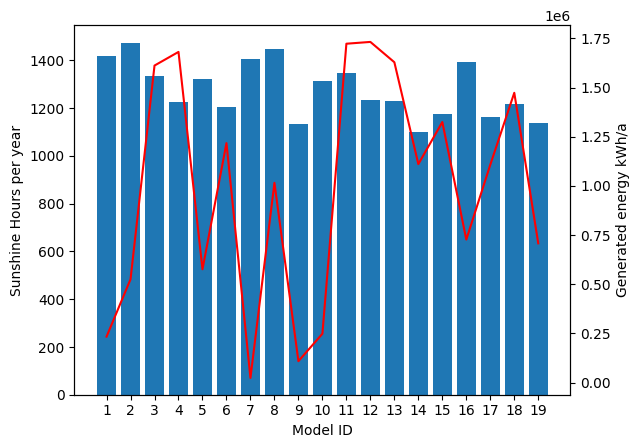

In [84]:
fig,ax = plt.subplots()
ax.bar(solar['Model ID'], solar['Sunshine Hours per year'])
ax.set_xticks(range(1,20))
ax.set_xlabel("Model ID")
ax.set_ylabel("Sunshine Hours per year")
ax2 = ax.twinx()
ax2.plot(solar['Model ID'], solar['Generated energy kWh/a'], color = 'red')
ax2.set_ylabel("Generated energy kWh/a")
fig.show()

In [85]:
solar['nw_price'] = solar['Size Solar Panel m2'] * 315.888 # same sunshine as sw
solar['ne_price'] = solar['Size Solar Panel m2'] * 149 # same sunshine as se
solar['sw_price'] = solar['Size Solar Panel m2'] * 159
solar['se_price'] = solar['Size Solar Panel m2'] * 134

solar_3000 = solar[solar['Size Solar Panel m2']<=3000]
solar_3000.set_index("Model ID", inplace = True)

solar_2000 = solar[solar['Size Solar Panel m2']<=2000]
solar_2000.set_index("Model ID", inplace = True)

- nw- model 10
- ne - model
- sw - model
- se - model

In [86]:
region = 'se_price'
sel_cols = ['Sunshine Hours per year',  'Size Solar Panel m2',  'Generated energy kWh/a', region]
solar_2000.loc[:, sel_cols].sort_values(by = ["Sunshine Hours per year",region, "Generated energy kWh/a"], ascending = [True, True, False])

,Sunshine Hours per year,Size Solar Panel m2,Generated energy kWh/a,se_price
Model ID,,,,
9,1133,449,108842,60166
10,1313,903,248448,121002
7,1406,81,23656,10854
1,1418,794,233616,106396
2,1474,1726,525410,231284


In [87]:
region = 'se_price'
sel_cols = ['Sunshine Hours per year',  'Size Solar Panel m2',  'Generated energy kWh/a', region]
solar_3000.loc[:, sel_cols].sort_values(by = ["Sunshine Hours per year",region, "Generated energy kWh/a"], ascending = [True, True, False])

,Sunshine Hours per year,Size Solar Panel m2,Generated energy kWh/a,se_price
Model ID,,,,
9,1133,449,108842,60166
19,1137,2912,708013,390208
10,1313,903,248448,121002
5,1320,2085,576313,279390
16,1394,2509,727268,336206
7,1406,81,23656,10854
1,1418,794,233616,106396
2,1474,1726,525410,231284


In [88]:
nw_ss_avg_yearly = nw.groupby("month")['Sunhine Hours'].agg("mean").sum()
ne_ss_avg_yearly = ne.groupby("month")['Sunhine Hours'].agg("mean").sum()
sw_ss_avg_yearly = sw.groupby("month")['Sunhine Hours'].agg("mean").sum()
se_ss_avg_yearly = se.groupby("month")['Sunhine Hours'].agg("mean").sum()


In [89]:
print(f"""
      nw_ss_avg_yearly: {nw_ss_avg_yearly}
      ne_ss_avg_yearly : {ne_ss_avg_yearly}
      sw_ss_avg_yearly : {sw_ss_avg_yearly}
      se_ss_avg_yearly : {se_ss_avg_yearly}""")


      nw_ss_avg_yearly: 1195.4725609243699
      ne_ss_avg_yearly : 1122.2143488612837
      sw_ss_avg_yearly : 1204.344192514124
      se_ss_avg_yearly : 1101.9248069381597


In [90]:
def maximize_profit():
  global para
  total = 0
  for id, data in para.items():
    total = total + (data[0].groupby("year")['Sunhine Hours'].agg("mean")[-1:]*12) * res.get("price")
  return total

maximize_profit()

,Sunhine Hours
year,
2022,765379.946619


In [91]:
nw_ss_avg_yearly = nw[nw['year']>=2021].groupby("month")['Sunhine Hours'].agg("mean").sum()
ne_ss_avg_yearly = ne[ne['year']>=2021].groupby("month")['Sunhine Hours'].agg("mean").sum()
sw_ss_avg_yearly = sw[sw['year']>=2021].groupby("month")['Sunhine Hours'].agg("mean").sum()
se_ss_avg_yearly = se[se['year']>=2021].groupby("month")['Sunhine Hours'].agg("mean").sum()

In [92]:
# Avg yearly Sunshine hours
print(f"""
      nw_ss_avg_yearly: {nw_ss_avg_yearly}
      ne_ss_avg_yearly : {ne_ss_avg_yearly}
      sw_ss_avg_yearly : {sw_ss_avg_yearly}
      se_ss_avg_yearly : {se_ss_avg_yearly}""")


      nw_ss_avg_yearly: 1252.8733088235294
      ne_ss_avg_yearly : 1158.945
      sw_ss_avg_yearly : 1254.4151666666667
      se_ss_avg_yearly : 1148.896153846154


In [94]:
region = 'sw_price'
sel_cols = ['Sunshine Hours per year', 	'Size Solar Panel m2',	'Generated energy kWh/a', region]
solar_3000.loc[:, sel_cols].sort_values(by = ["Sunshine Hours per year",region, "Generated energy kWh/a"], ascending = [True, True, False])

,Sunshine Hours per year,Size Solar Panel m2,Generated energy kWh/a,sw_price
Model ID,,,,
9,1133,449,108842,71391
19,1137,2912,708013,463008
10,1313,903,248448,143577
5,1320,2085,576313,331515
16,1394,2509,727268,398931
7,1406,81,23656,12879
1,1418,794,233616,126246
2,1474,1726,525410,274434


In [98]:
solar_3000

,Sunshine Hours per year,Size Solar Panel m2,Generated energy kWh/a,nw_price,ne_price,sw_price,se_price
Model ID,,,,,,,
1,1418,794,233616,250815.072,118306,126246,106396
2,1474,1726,525410,545222.688,257174,274434,231284
5,1320,2085,576313,658626.480,310665,331515,279390
7,1406,81,23656,25586.928,12069,12879,10854
9,1133,449,108842,141833.712,66901,71391,60166
10,1313,903,248448,285246.864,134547,143577,121002
16,1394,2509,727268,792562.992,373841,398931,336206
19,1137,2912,708013,919865.856,433888,463008,390208


<Axes: xlabel='Model ID'>

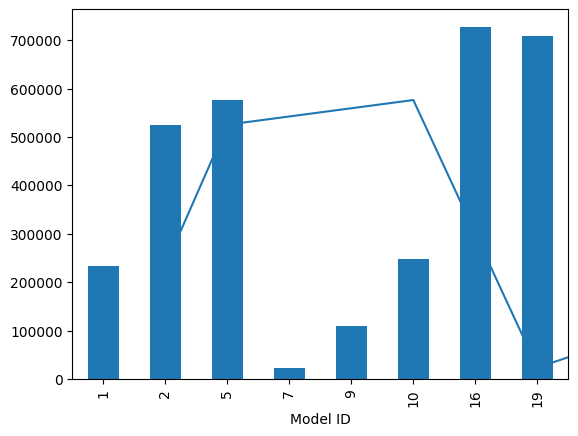

In [97]:
solar_3000['Generated energy kWh/a'].plot()
solar_3000['Generated energy kWh/a'].plot(kind = "bar")


#For 3 Million Budget

##South - West Area is most suitable with :
  - Sunshine Hours per year = 10595 hr
  - Size Solar Farm = 11459 m²
  - Generated energy kWh/a = 3144566 kWh/a
  - South-west land price = 1821981 euro
  - solar panel setup cost per 100(1m²) * 11459 m² = 1145900 euro

##Total cost = 2967881 (2.9M)

###Which is under the budget with 3 Million euro budget we can produce 3.1 million Kwh/a where as with 2 million budget we cannot achieve the 2 million Kwh/a energy need.
